# **Statistics(I)(2) - Final Project Code**
## **Task 1**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy import stats
import seaborn as sns
import math
from scipy.stats import bartlett
from statsmodels.formula.api import ols
from statsmodels.stats.libqsturng import qsturng
from statsmodels.stats.multicomp import MultiComparison

In [2]:
def f_test_variances(x1, x2, sides, alpha):
    a1 = np.array(x1)
    a2 = np.array(x2)

    result = np.full((7, 2), None, dtype=float)
    
    result[0] = [np.mean(a1), np.mean(a2)]                    # Means
    result[1] = [np.std(a1, ddof=1), np.std(a2, ddof=1)]      # Sample standard deviations
    result[2] = [a1.size, a2.size]                            # Sample sizes

    dfn, dfd = a1.size - 1, a2.size - 1
    result[3] = [dfn, dfd]

    # F-statistic: ratio of sample variances
    f_stat = np.var(a1, ddof=1) / np.var(a2, ddof=1)
    result[4, 0] = f_stat

    # Critical F-values
    if sides > 1:
        result[5] = [
            stats.f.isf(alpha / 2, dfn, dfd),  # Upper critical value
            stats.f.ppf(alpha / 2, dfn, dfd)   # Lower critical value
        ]
    else:
        result[5] = [
            stats.f.isf(alpha, dfn, dfd),      # One-sided critical value
            stats.f.ppf(alpha, dfn, dfd)
        ]

    if f_stat > 1:
        p_value = 1 - stats.f.cdf(f_stat, dfn, dfd)
    else:
        p_value = stats.f.cdf(f_stat, dfn, dfd)
    if sides > 1:
        p_value *= 2
    result[6, 0] = p_value

    labels = ['Mean', 'Std Dev', 'Size', 'Degrees of Freedom', 'F-statistic', 'F-critical', 'p-value']
    df = pd.DataFrame(result, index=labels)

    return df

In [3]:
def t_test_summary(x1, x2, usevar='pooled', alpha=0.05):
    """
    Runs a t-test using statsmodels' CompareMeans and prints a summary.

    Parameters:
    - df: DataFrame containing the columns
    - col1, col2: Column names to compare
    - usevar: 'pooled' (equal variances) or 'unequal' (Welch)
    - alpha: Significance level
    """
    group1 = sms.DescrStatsW(x1)
    group2 = sms.DescrStatsW(x2)
    t_test = sms.CompareMeans(group1, group2)
    
    return t_test.summary(usevar=usevar, alpha=alpha)

In [4]:
def chi_square_normality_test(data, bins=8):
    counts, edges = np.histogram(data, bins=bins)
    mu, sigma = np.mean(data), np.std(data)
    expected_probs = stats.norm.cdf(edges[1:], mu, sigma) - stats.norm.cdf(edges[:-1], mu, sigma)
    expected_counts = expected_probs * len(data)
    expected_counts *= counts.sum() / expected_counts.sum()
    # 卡方檢定
    stat, p = stats.chisquare(f_obs=counts, f_exp=expected_counts)
    return stat, p

In [5]:
def oneway_anova(df, response_col, factor_col):
    """
    Runs a one-way ANOVA on the given dataframe.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - response_col: name of the numeric response variable
    - factor_col: name of the categorical factor

    Returns:
    - ANOVA summary table (DataFrame)
    """
    
    formula = f'{response_col} ~ C({factor_col})'
    model = ols(formula, data=df).fit()
    aov_table = sms.anova_lm(model, typ=2)
    
    print("\nANOVA Table:")
    display(aov_table)


In [6]:
def tukey_hsd(df, response_col, factor_col, alpha=0.05, comparison_focus=None):
    """
    Performs Tukey's HSD test and plots confidence intervals.

    Parameters:
    - df: pandas DataFrame
    - response_col: Dependent variable
    - factor_col: Categorical independent variable
    - alpha: Significance level (default 0.05)
    - comparison_focus: Optional group name to center the plot on

    Returns:
    - Tuple of (summary table, omega)
    """
    group_sizes = df.groupby(factor_col).size()
    k = len(group_sizes)
    df_within = df.shape[0] - k
    
    ng = k / np.sum(1 / group_sizes)

    model = smf.ols(f"{response_col} ~ C({factor_col})", data=df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    mse = aov_table.loc["Residual", "sum_sq"] / aov_table.loc["Residual", "df"]

    q_crit = qsturng(1 - alpha, k, df_within)
    omega = q_crit * np.sqrt(mse / ng)

    tukey = MultiComparison(df[response_col], df[factor_col])
    tukey_result = tukey.tukeyhsd(alpha=alpha)

    print(f"Q critical value = {q_crit:.6f}")
    print(f"Tukey Omega = {omega:.6f}")
    print(tukey_result.summary())

    _ = tukey_result.plot_simultaneous()
    plt.title("Tukey HSD Confidence Intervals")
    plt.show()

    if comparison_focus:
        _ = tukey_result.plot_simultaneous(comparison_name=comparison_focus)
        plt.title(f"Tukey HSD Focused on: {comparison_focus}")
        plt.show()

    return tukey_result.summary(), omega

---

In [7]:
df = pd.read_csv("movie_summary.csv")

filtered_df = df[
    (df['production_budget'] > 0) &
    (df['production_year'] > 2000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()
filtered_df["total_box_office"] = filtered_df["domestic_box_office"] + filtered_df["international_box_office"]

filtered_df["flattened_production_budget"] = np.power(filtered_df["production_budget"], 1/4)
filtered_df["flattened_total_box_office"] = np.power(filtered_df["total_box_office"], 1/4)

filtered_df['z_score_bu'] = stats.zscore(filtered_df['production_budget'])
filtered_df['z_score_bo'] = stats.zscore(filtered_df['total_box_office'])
filtered_df = filtered_df[filtered_df['z_score_bu'].abs() <= 2].copy()
filtered_df = filtered_df[filtered_df['z_score_bo'].abs() <= 2].copy()
print(filtered_df["production_budget"].min())
print(filtered_df["production_budget"].max())
# 預算分4組，每組1000萬
bin_edges = [0, 10_000_000, 20_000_000, 30_000_000, np.inf]
bin_labels = ['0_1000w', '1000_2000w', '2000_3000w', '3000_4000w']
filtered_df['budget_group'] = pd.cut(
    filtered_df['production_budget'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

# 分四組完整的 DataFrame
grouped_df = {
    label: filtered_df[filtered_df['budget_group'] == label].copy()
    for label in bin_labels
}

group_shapes = {label: df.shape for label, df in grouped_df.items()}
display(group_shapes)
variances = {label: df["flattened_total_box_office"].std(ddof=1) for label, df in grouped_df.items()}
display(variances)


1100
130000000


{'0_1000w': (1190, 29),
 '1000_2000w': (690, 29),
 '2000_3000w': (455, 29),
 '3000_4000w': (1084, 29)}

{'0_1000w': np.float64(26.464574753159514),
 '1000_2000w': np.float64(24.303404478304603),
 '2000_3000w': np.float64(22.15869965822924),
 '3000_4000w': np.float64(23.721726502687634)}

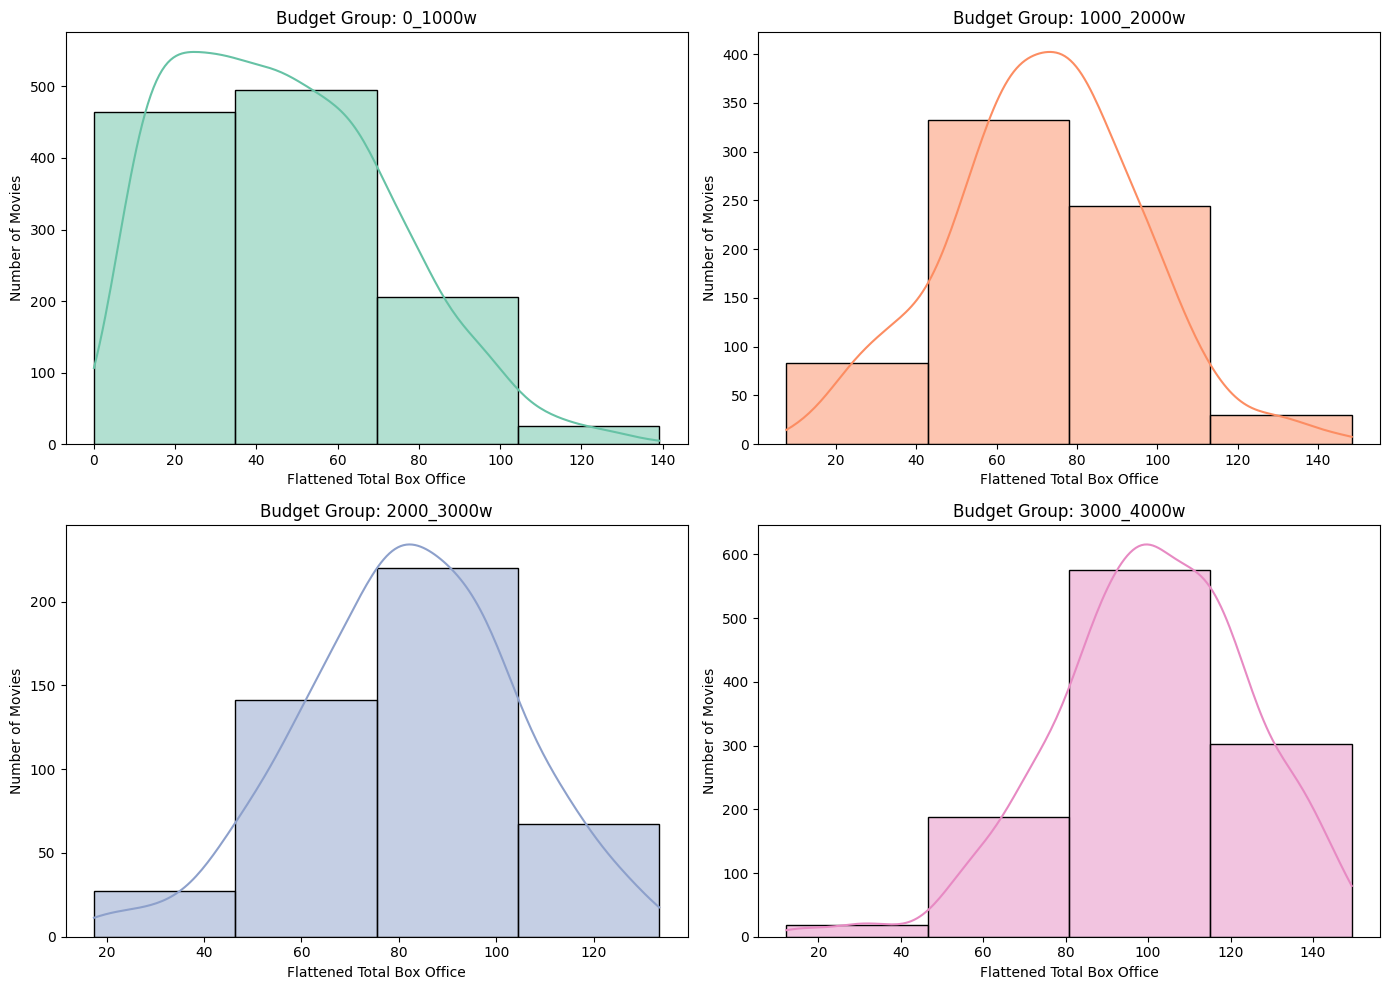

In [8]:
# 畫每個組別的票房分布
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, label in enumerate(['0_1000w', '1000_2000w', '2000_3000w', '3000_4000w']):
    sns.histplot(
        data=grouped_df[label],
        x='flattened_total_box_office',
        bins=4,
        kde=True,
        ax=axes[i],
        color=sns.color_palette("Set2")[i]
    )
    axes[i].set_title(f"Budget Group: {label}")
    axes[i].set_xlabel("Flattened Total Box Office")
    axes[i].set_ylabel("Number of Movies")

plt.tight_layout()
plt.show()

In [9]:
# 執行常態檢定
for label, df_group in grouped_df.items():
    x = df_group["flattened_total_box_office"]
    display(x.head())
    # Shapiro-Wilk test
    s_stat, s_p = stats.shapiro(x)

    # Chi-square test
    try:
        c_stat, c_p = chi_square_normality_test(x, 4)
        chi_msg = f"χ² = {c_stat:.4f}, p = {c_p:.4f} → {'常態' if c_p > 0.05 else '不常態'}"
    except ValueError as e:
        chi_msg = f"Chi-square 檢定失敗：{e}"

    print(f"\n預算組別：{label}")
    print(f"Shapiro-Wilk  : W = {s_stat:.4f}, p = {s_p:.4f} → {'常態' if s_p > 0.05 else '不常態'}")
    print(f"Chi-square    : {chi_msg}")

54     139.147681
165    123.342954
237    121.947029
272    116.983200
371    111.203815
Name: flattened_total_box_office, dtype: float64


預算組別：0_1000w
Shapiro-Wilk  : W = 0.9676, p = 0.0000 → 不常態
Chi-square    : χ² = 50.3280, p = 0.0000 → 不常態


169    140.033738
197    113.281028
206    127.158195
228    114.178301
325    120.058559
Name: flattened_total_box_office, dtype: float64


預算組別：1000_2000w
Shapiro-Wilk  : W = 0.9960, p = 0.0757 → 常態
Chi-square    : χ² = 0.3866, p = 0.9430 → 常態


122    132.343743
152    121.686612
156    128.721955
158    116.767672
160    122.737853
Name: flattened_total_box_office, dtype: float64


預算組別：2000_3000w
Shapiro-Wilk  : W = 0.9938, p = 0.0619 → 常態
Chi-square    : χ² = 1.6800, p = 0.6414 → 常態


38    146.906665
39    148.918947
52    146.581278
53    148.359858
60    142.146667
Name: flattened_total_box_office, dtype: float64


預算組別：3000_4000w
Shapiro-Wilk  : W = 0.9862, p = 0.0000 → 不常態
Chi-square    : χ² = 7.0575, p = 0.0701 → 常態


In [10]:
# 經過 z score 篩選後的票房最小值
min_box_office = filtered_df['total_box_office'].min()
print(f"經過 z score 篩選後的票房最小值為: {min_box_office}")

經過 z score 篩選後的票房最小值為: 0


In [59]:
# Extract the values from each group
group_values = [df_group["flattened_total_box_office"].values for df_group in grouped_df.values()]

# Run Bartlett's test
b_stat, b_p = bartlett(*group_values)
bart_msg = f"Bartlett’s test: stat = {b_stat:.4f}, p = {b_p:.4f} → {'變異數相同' if b_p > 0.05 else '變異數不相同'}"
print(bart_msg)

Bartlett’s test: stat = 25.5666, p = 0.0000 → 變異數不相同


In [60]:
exclusive_labels = ['1000_2000w', '2000_3000w', '3000_4000w']
exclusive_group_values = [
    df["flattened_total_box_office"].values
    for label, df in grouped_df.items()
    if label in exclusive_labels
]

# Run Bartlett's test
b_stat, b_p = bartlett(*exclusive_group_values)
bart_msg = f"Bartlett’s test: stat = {b_stat:.4f}, p = {b_p:.4f} → {'變異數相同' if b_p > 0.05 else '變異數不相同'}"
print(bart_msg)


Bartlett’s test: stat = 4.7253, p = 0.0942 → 變異數相同


In [61]:
exclusive_df = filtered_df[filtered_df['budget_group'].isin(exclusive_labels)]
oneway_anova(exclusive_df, 'flattened_total_box_office', 'budget_group')


ANOVA Table:


,sum_sq,df,F,PR(>F)
C(budget_group),1.758664e+07,3.0,10529.518788,0.0
Residual,1.239305e+06,2226.0,NaN,NaN


C:\Users\User\AppData\Local\Temp\ipykernel_2688\2351131295.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_sizes = df.groupby(factor_col).size()
C:\Users\User\AppData\Local\Temp\ipykernel_2688\2351131295.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  omega = q_crit * np.sqrt(mse / ng)


Q critical value = 3.635909
Tukey Omega = inf
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
1000_2000w 2000_3000w   9.7757   0.0  6.4338 13.1176   True
1000_2000w 3000_4000w   28.881   0.0  26.186  31.576   True
2000_3000w 3000_4000w  19.1053   0.0 16.0141 22.1964   True
-----------------------------------------------------------


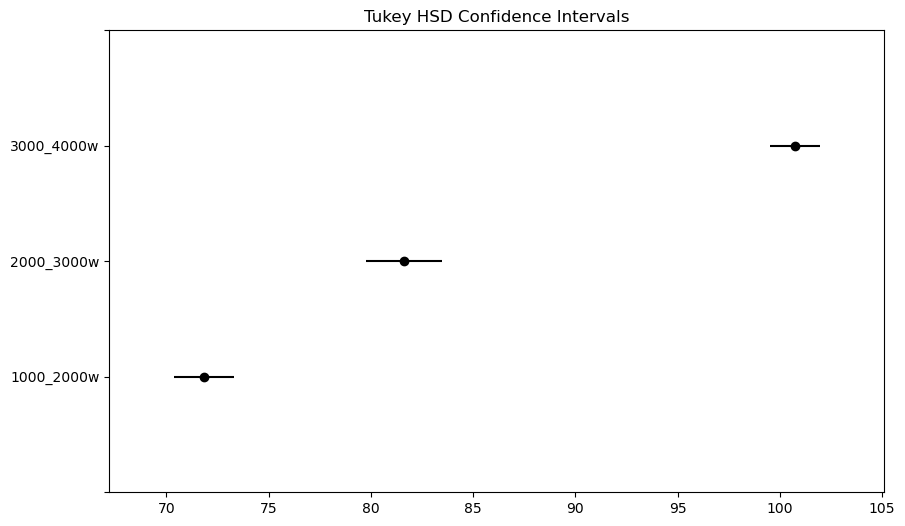

group1,group2,meandiff,p-adj,lower,upper,reject
1000_2000w,2000_3000w,9.7757,0.0,6.4338,13.1176,True
1000_2000w,3000_4000w,28.881,0.0,26.186,31.576,True
2000_3000w,3000_4000w,19.1053,0.0,16.0141,22.1964,True


inf

In [64]:
summary, omega = tukey_hsd(
    df=exclusive_df,
    response_col='flattened_total_box_office',
    factor_col='budget_group',
    alpha=0.05,
    comparison_focus=None
)
display(summary)
display(omega)